## *Historical and Sociocultural Analysis of the Impact of World Events on Film Genre Trends*

 This project will explore historical trends in film genres, analyzing how societal and historical events—such as wars, economic shifts, and cultural influences—affect the popularity of genres. 
 The goal is to understand how historical events and cultural dynamics shape film genre trends over time and understand how periods of conflict, economic upheaval, or stability shape audience preferences and genre popularity.

In [61]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
from src.utils.appendix import *

from statsmodels.formula.api import ols
from scipy.stats import kruskal
from scipy.stats import shapiro
import statsmodels.api as sm
from sklearn.metrics import r2_score

%load_ext autoreload
%autoreload 2
from src.utils.data_cleaning2 import *
from src.utils.visualization import *
from src.utils.appendix import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Movies Dataset

For this part of the notebook, we will use the provided movie dataset, which has been cleaned and preprocessed specifically for our project. We will focus on key columns that are particularly relevant to our analysis, notably the genres of the movies and the countries involved in their production.

In [62]:
raw_movies_data = pd.read_csv("data/MoviesDataset/movie.metadata.zip", header= None, delimiter='\t')
clean_movies_data = preprocess_movies(raw_movies_data)
processed_data_path = 'data/Preprocessed_data/preprocessed_movie_metadata.csv'
clean_movies_data.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)

In [63]:
preprocessed_movies = pd.read_csv(processed_data_path)
preprocessed_movies.head(2)

,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
0,Ghosts of Mars,14010832.0,98.0,English,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001
1,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000


Before diving into specific case studies, such as examining the popular film genres around the time of World War II, we will take a broader approach. First, we will analyze the most represented genres by decade and by country. Additionally, we will conduct an initial exploration to see if there are any apparent correlations between these trends and the historical events in our dataset.

First, we take the most popular movie genres based on sources (https://www.statista.com/statistics/188658/movie-genres-in-north-america-by-box-office-revenue-since-1995/ & https://www.the-numbers.com/market/genres).

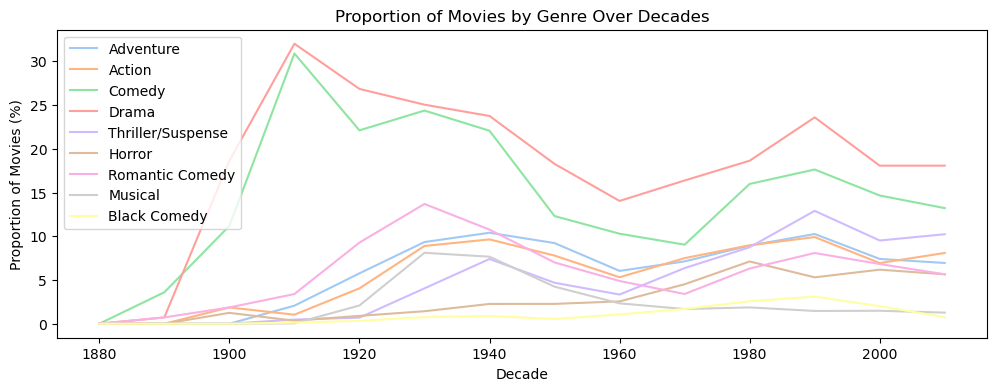

In [64]:
# Lets select some of the genres :
genres = ["Adventure","Action","Comedy","Drama","Thriller/Suspense",
          "Horror","Romantic Comedy","Musical","Black Comedy"]

# Filter the preprocessed movies to only include the selected genres
filtered_movies = preprocessed_movies[preprocessed_movies['Genres'].str.contains('|'.join(genres), case=False, na=False)]
genre_counts = filtered_movies['Genres'].str.split(', ').explode().value_counts()
filtered_genre_counts = genre_counts[genre_counts.index.isin(genres)]

related_genres = {
    "Adventure": ["Adventure", "Adventure Comedy", "Action/Adventure"],
    "Action": ["Action", "Action/Adventure", "Action Comedy", "Action Thrillers"],
    "Comedy": ["Comedy", "Comedy-drama", "Adventure Comedy", "Black comedy", "Romantic comedy", 
               "Comedy horror", "Musical comedy", "Screwball comedy", "Comedy Western", "Comedy Thriller"],
    "Drama": ["Drama", "Comedy-drama", "Romantic drama", "Political drama", "Historical drama", 
              "Family Drama", "Melodrama"],
    "Thriller/Suspense": ["Thriller", "Suspense", "Crime Thriller", "Psychological thriller", 
                          "Erotic thriller", "Political thriller"],
    "Horror": ["Horror", "Natural horror films", "Horror Comedy", "Psychological horror", "Slasher"],
    "Romantic Comedy": ["Romantic comedy", "Romantic drama", "Romance Film"],
    "Musical": ["Musical", "Musical comedy", "Musical Drama", "Animated Musical"],
    "Black Comedy": ["Black comedy", "Dark comedy", "Satire", "Comedy Thriller"]
}

# Calculate total movies per decade
total_movies_per_decade = group_by_decade(preprocessed_movies.copy())

plot_movie_genres_per_decade(related_genres,total_movies_per_decade,preprocessed_movies)

We are already seeing a number of things: 
- The rise of the “Musical” in the 1930s-1950s: This peak may coincide with the rise of Hollywood musicals after the Great Depression and during the Second World War, a period when entertainment was important.
- The gradual decline of “Dramas” after 1940: This may be linked to a shift in public demand towards lighter or more spectacular genres (such as action and adventure).
- The rise of “Thrillers/Suspense” and “Horror” after 1960-1980: May coincide with periods of social or political tension (Cold War, oil crisis).
-The rise of Action films from the 1980s: This could be linked to technological advances in special effects and the rise of iconic heroes.

## Historical Events Dataset

Initially, we integrated the <u>*World Important Events: Ancient to Modern*</u> dataset to explore correlations between historical events and film genre trends. While it provided comprehensive coverage of events, its scope and complexity posed challenges for analysis and interpretation in our specific context. However, we will sometimes use it as a complement, which is why we still preprocess it as follows:

In [65]:
raw_history_data= pd.read_csv("data/HistoricalDataset/historical.dataset.zip")
first_movie_year = preprocessed_movies['Year'].min()
last_movie_year = preprocessed_movies['Year'].max()
cleaned_events = preprocess_events(raw_history_data, first_movie_year, last_movie_year)
events_countries = cleaned_events['Country'].unique()
movies_countries = preprocessed_movies['Countries'].str.split(', ').explode().unique()
#Elements in events_countries that are not in movies_countries
not_in_movies_dataset = [item for item in events_countries if item not in movies_countries]
cleaned_events = cleaned_events[cleaned_events['Country'].isin(movies_countries)]
preprocessed_history = cleaned_events.copy()

To remedy this, we created a new dataset manually, with the help of a linguistic model (LM) and our own ideas that we felt were relevant. 

Since it is a small, hand-crafted dataset, no preprocessing is required. Here are a few lines:

In [66]:
historical_events_df = pd.read_csv("data/manual_historical_dataset.csv")
historical_events_df.head()

,Event Name,Year,Location,Impact Type,Description
0,World War II,1939,Global,Negative,A global conflict between Axis and Allied powe...
1,Great Depression,1929,USA,Negative,A worldwide economic downturn causing massive ...
2,Civil Rights Movement,1954,USA,Mixed,A struggle for African Americans' equality and...
3,Cold War,1947,Global,Mixed,A period of political and military tension bet...
4,Vietnam War,1955,USA,Negative,A conflict between communist North Vietnam and...


Here are some visualizations of the historical dataset to give an overview of its contents and composition:

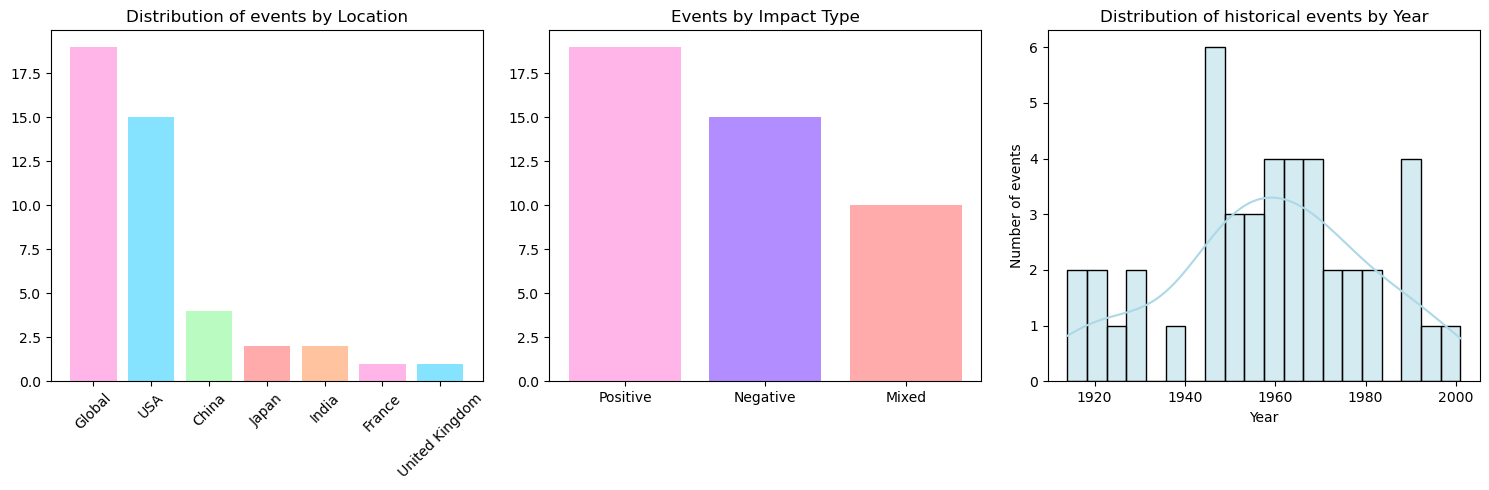

In [67]:
plot_first_look_historical(historical_events_df)

## Cross-Referenced Dataset: Historical Events and Movies

Now, let’s take a first look at the potential correlations between our historical events dataset and the distribution of the most prominent movie genres over time:

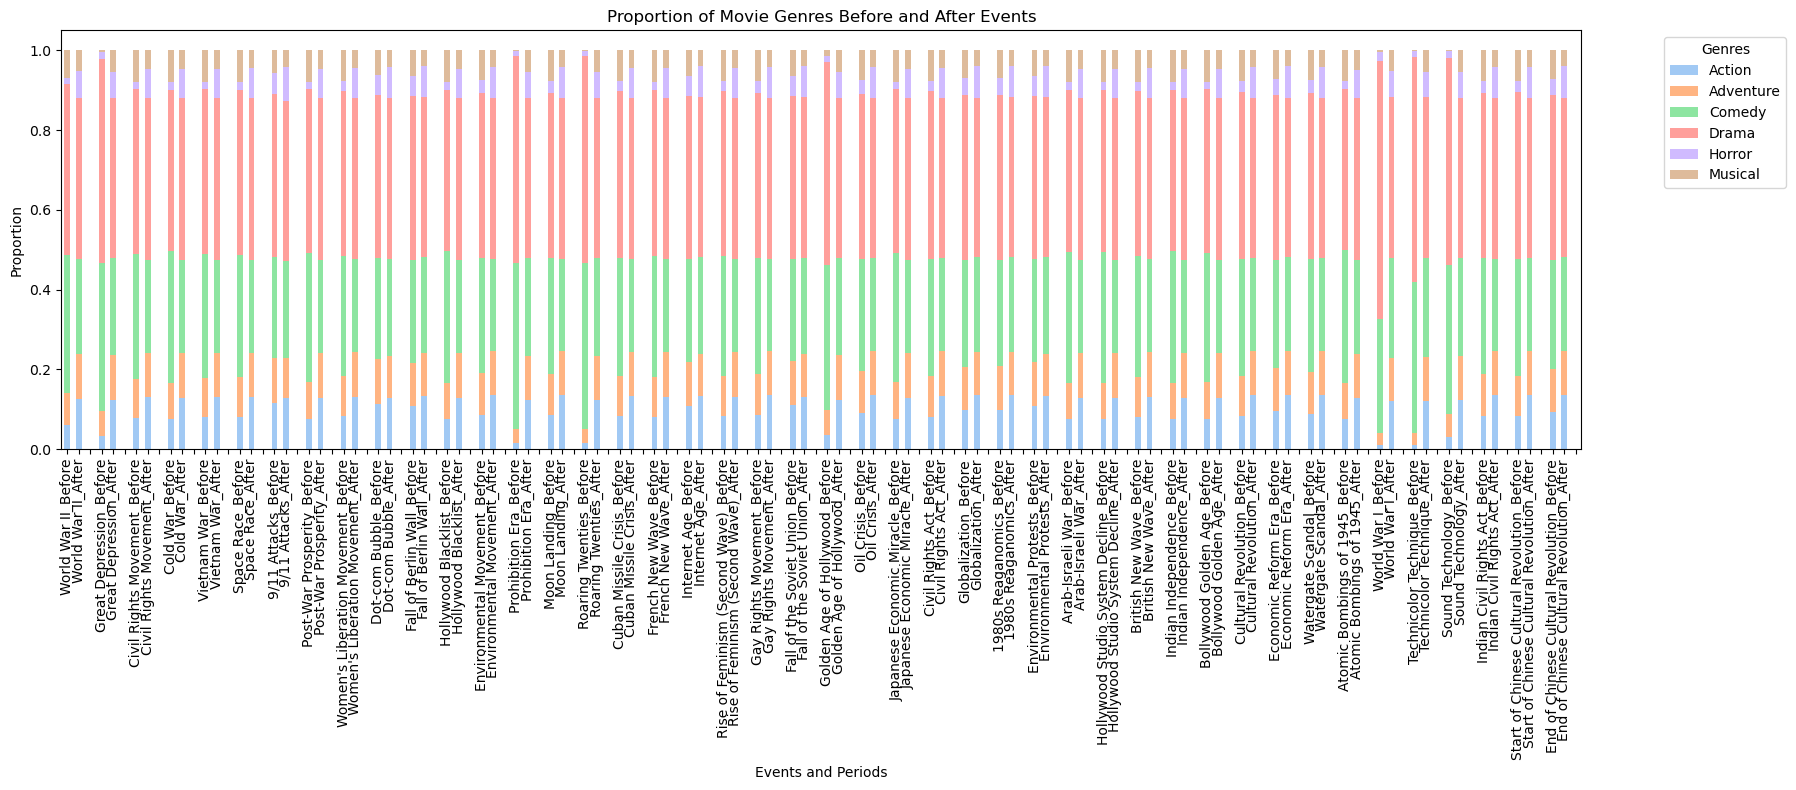

In [68]:
#Global plot to motivate our question
historical = historical_events_df.copy()
movies = preprocessed_movies.copy()

genres_of_interest = [ "Adventure", "Action", "Comedy", "Drama", "Thriller/Suspense",
                        "Horror", "Romantic Comedy", "Musical", "Black Comedy"]

movies['Filtered_Genres'] = movies['Genres'].apply(
    lambda x: genre_filter(x, genres_of_interest)
)
movies = movies.explode('Filtered_Genres').dropna(
    subset=['Filtered_Genres']
)

plot_global_plot(historical,movies)

The stacked bar plot above provides an overview of the changes in movie genre proportions before and after significant historical events. For each event, the "Before" and "After" distributions are allowing us to observe any shifts in the prominence of certain genres.

From this plot, we can observe that:

-Comedy and Drama consistently dominate the overall genre distribution, regardless of the event period.

-The proportions of action-related genres (Action and Adventure) tend to increase after certain events, possibly reflecting a cultural or societal shift toward escapism or hero-centric narratives.

-Other genres, such as Musical and Horror, remain minor yet show specific spikes after certain events, suggesting a contextual influence.

While the global plot provides an overall view of genre proportions before and after historical events, certain events stand out with notable shifts in genre trends.  
➔ To better understand these changes, we zoom into specific events where differences are most significant.

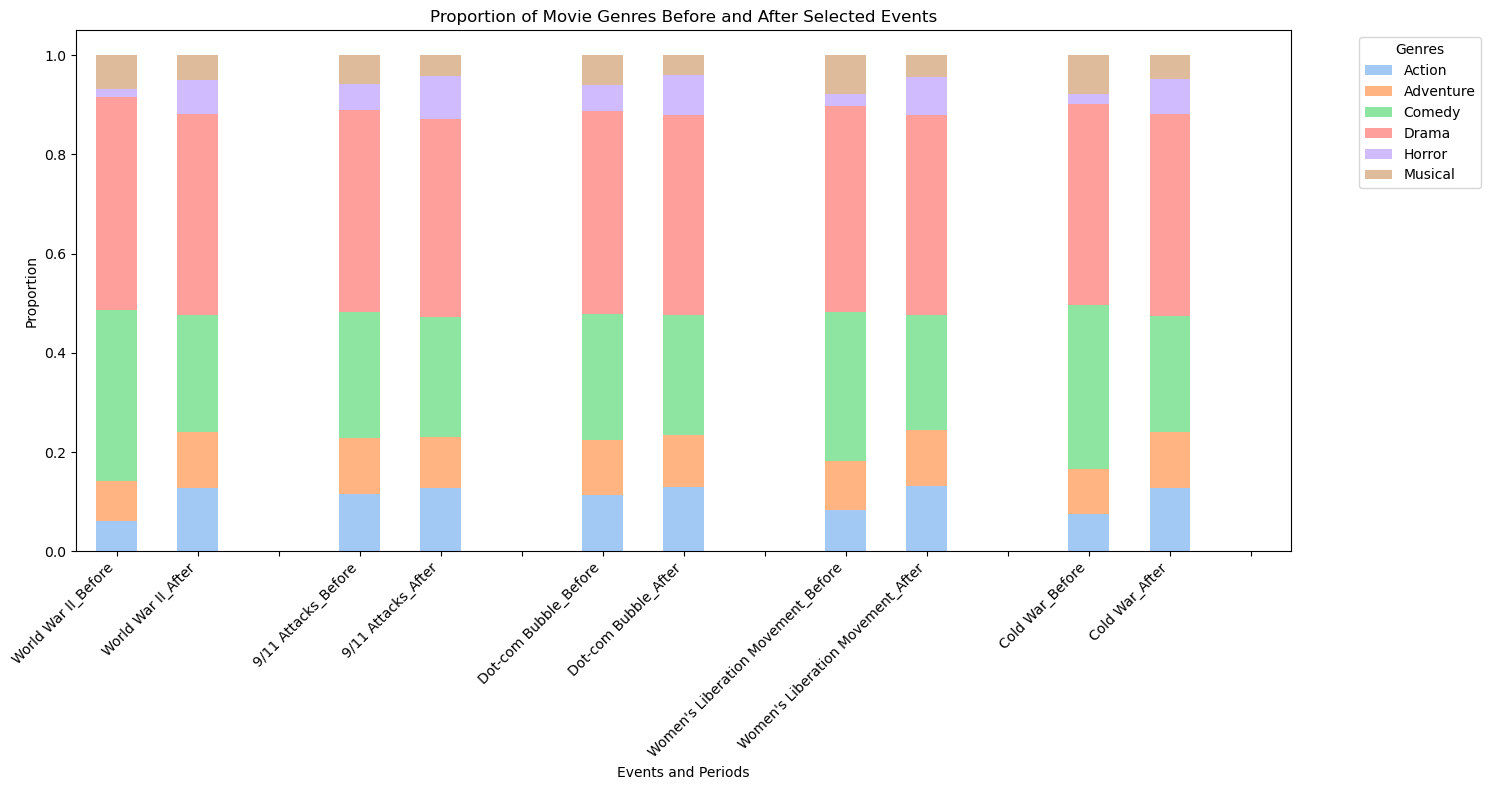

In [69]:
#We have selected a few events where the differences are most apparent to zoom on them
events_to_zoom = ["World War II", "9/11 Attacks", "Dot-com Bubble", "Women's Liberation Movement", "Cold War"]

plot_selected_events(historical, movies, events_to_zoom)

The plot reveals how historical events influence movie genre preferences. 

After **World War II** and the **Cold War**, *Action* and *Adventure* genres slightly increase, reflecting themes of heroism and conflict. 

Following the **9/11 Attacks**, a notable rise in *Action* highlights societal focus on resilience. 

The **Dot-com Bubble** maintains steady *Comedy* and *Adventure*, indicating a preference for escapism during economic uncertainty. 

The **Women's Liberation Movement** sees stable *Drama*, reflecting attention to societal narratives. 

Overall, the plot shows that periods of conflict or upheaval often drive shifts toward action-oriented and reflective storytelling.

For greater clarity, we have segmented our dataset by the most represented countries and plotted important global and specific country events:

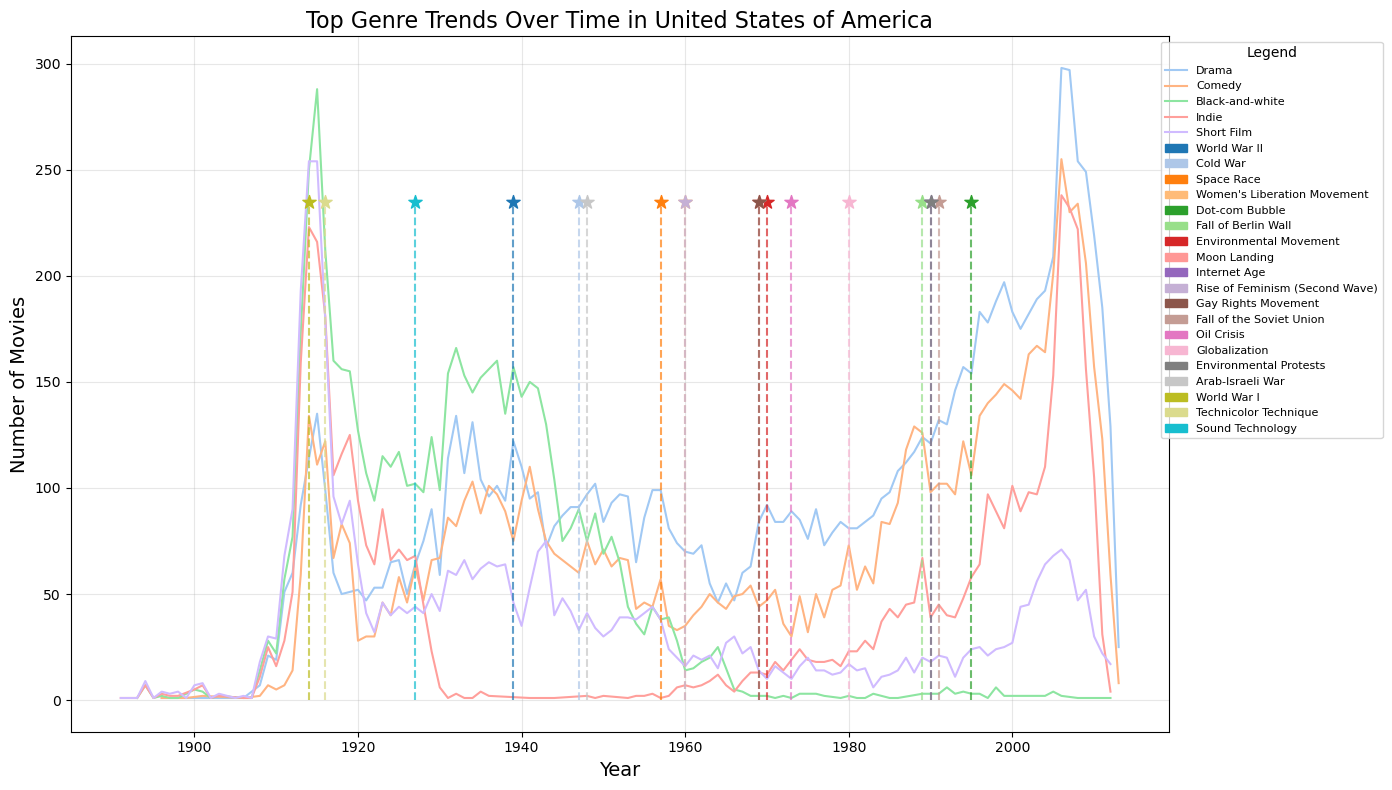

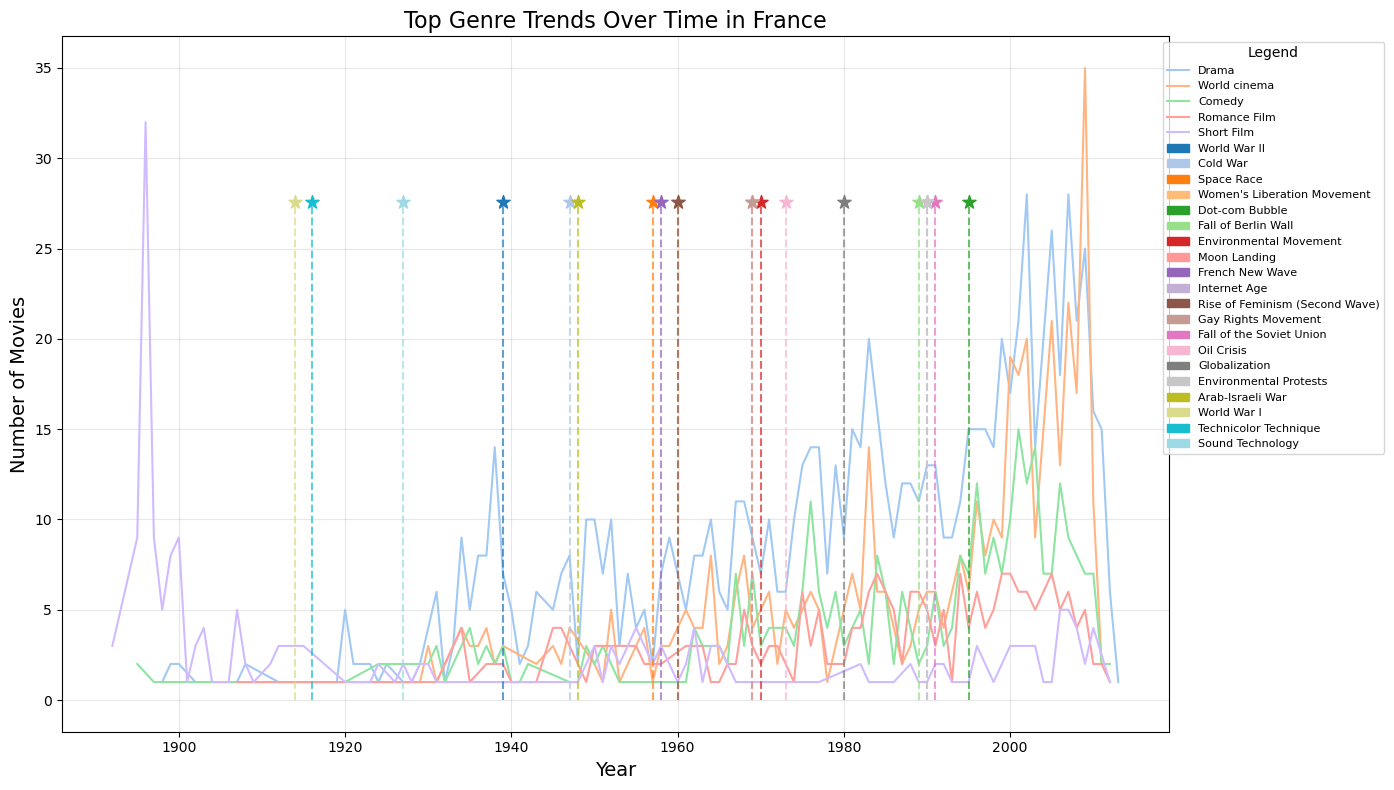

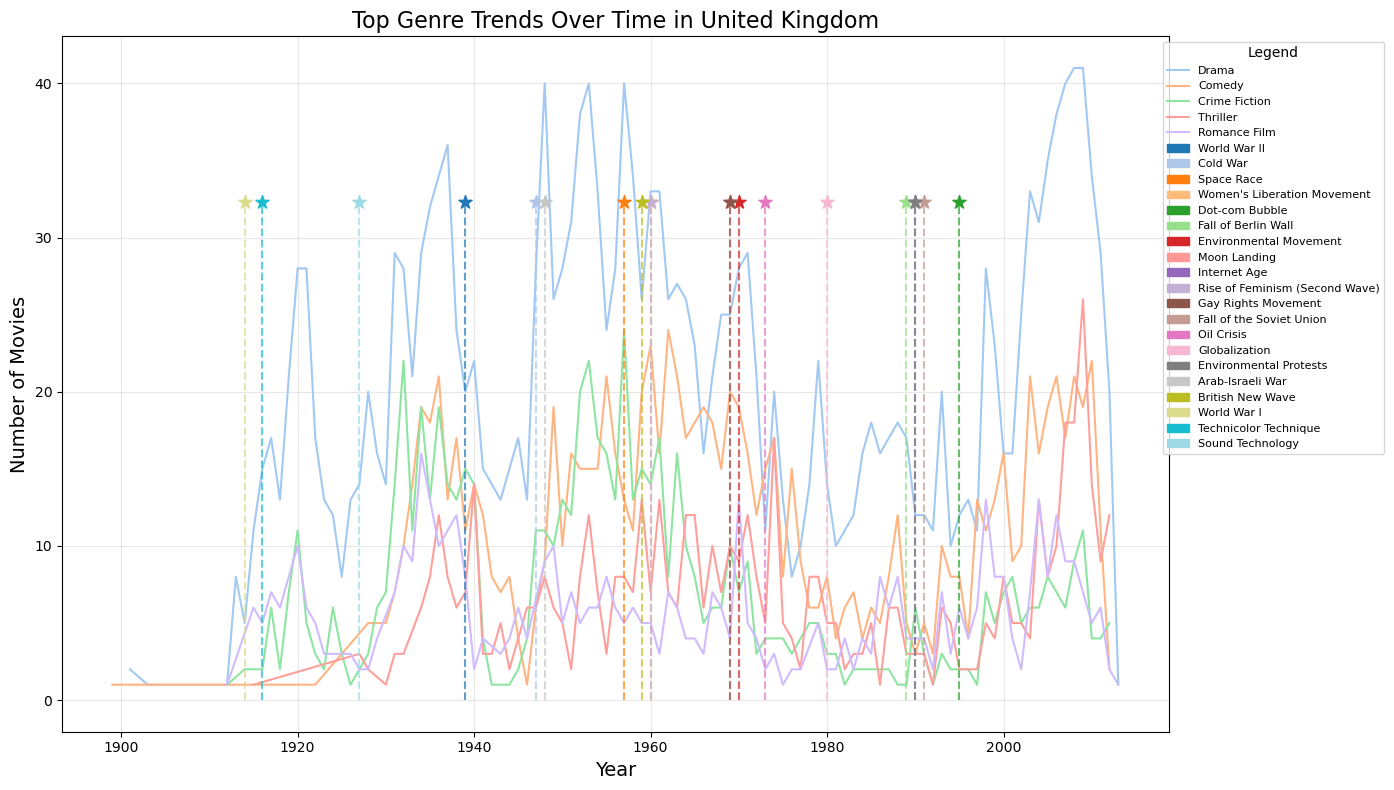

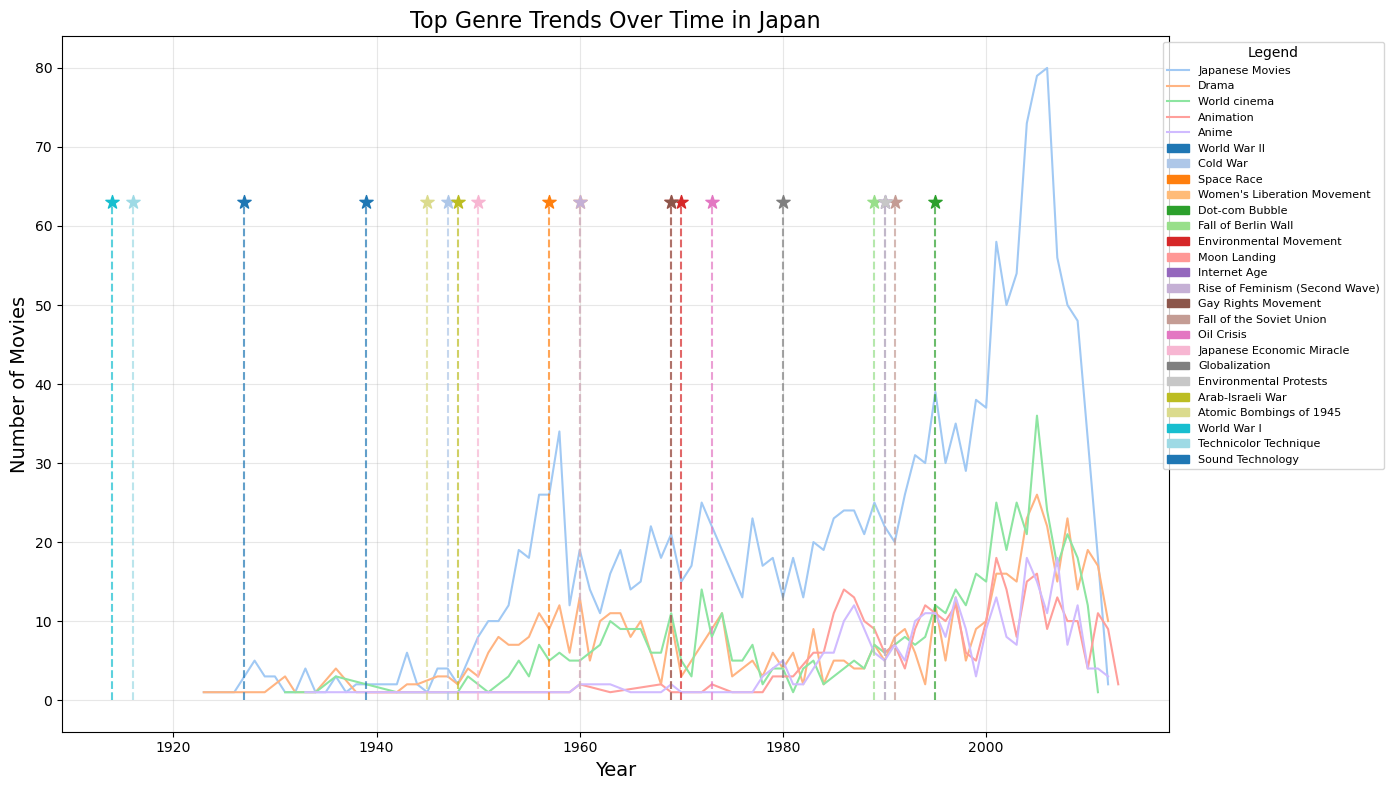

In [70]:
movie_metadata = preprocessed_movies.copy()
historical_data = historical_events_df.copy()

movie_metadata['Genres'] = movie_metadata['Genres'].str.split(', ')
genres_over_time = movie_metadata.explode('Genres').groupby(['Year', 'Genres']).size().reset_index(name='Count')

#Display of most represented countries and top genres
countries = ["United States of America", "France", "United Kingdom", "Japan"]

for country in countries:
    plot_genre_trends_per_country(country,historical_data,movie_metadata)

We cannot see the details clearly from these plots, so let’s focus on some examples starting by one of the most significant and impactful cases: World War II. We will now take a closer look at the trends surrounding war movies during this period.

## **Influence of history over film industry: Immediate or long-lasting effect ?**

In this analysis, we will explore how major historical events and broader social movements influence the film industry. 

We will also explore how the development of technologies in the movie industry, such as advancements in visual effects, sound, and cinematography, has impacted filmmaking trends. Additionally, we will assess the role of commercially successful movies that may set new standards or inspire a wave of similar films. Then, we will explore the impact of globalization and opening politics on Asian movies. Finally, we will investigate the influence of cultural and social movements, which often reflect or drive societal changes and shape the themes and narratives depicted in movies.

Our goal is to determine whether such events lead to immediate, short-term spikes in the production of specific types of films or whether they contribute to long-term, sustained trends over time. By identifying these patterns, we aim to better understand the relationship between significant moments in history and their lasting impact on cinema.

To illustrate this, we will examine around twenty pairs of examples, starting by Major historical events:

## **I) Major historical events** 

1) **War Movies/ World War II**

2) **Propaganda movies/ World War II**

3) **Film Noir/ World War II**

4) **Political films/ Watergate scandal**

5) **Spy Movies/ Cuban Missile Crisis**

6) **Creature Movies/ Atomic Bomb**

7) **Crime Movies/ Prohibition in USA**

8) **Melodramas/ World War I**

9) **Rise of Musicals/ Great Depression** 


We will test wether these movements led to gradual, sustained increases orn short-term spikes in related-topic movie production.

###  ★ War Movies and WWII

In [71]:
War_movies = preprocessed_movies[preprocessed_movies['Genres'].str.contains(r'war', case=False, na=False)]
War_movies_comedy = War_movies[War_movies['Genres'].str.contains(r'comedy', case=False, na=False)]
War_movies_drama = War_movies[War_movies['Genres'].str.contains(r'drama', case=False, na=False)]

print(f"Total number of War movies: {len(War_movies)}")
print(f"Total number of War-Comedy movies: {len(War_movies_comedy)}")
print(f"Total number of War-Drama movies: {len(War_movies_drama)}")


Total number of War movies: 2467
Total number of War-Comedy movies: 225
Total number of War-Drama movies: 1656


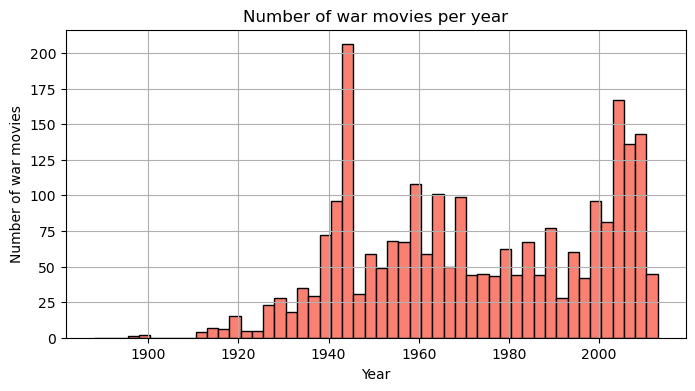

In [72]:
plot_war_movies(War_movies, preprocessed_movies)

The plot shows the number of war movies produced each year. There is a significant increase in war movie production during the 1940s, which aligns with World War II, suggesting that the conflict likely influenced the film industry. Another peak appears around the early 2000s.

We will create plots to analyze the proportion of war-themed movies, distinguishing between comedic and dramatic genres, and to investigate regional differences in how war is depicted through cinema. By comparing European countries, where the war took place, to the USA, the world's largest movie producer, we aim to understand how regional experiences influence the representation of war in film:  


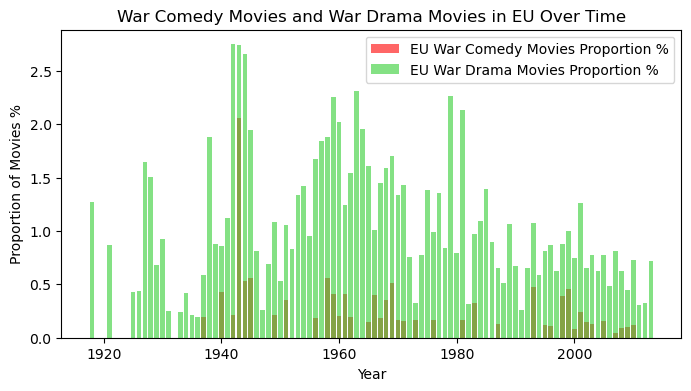

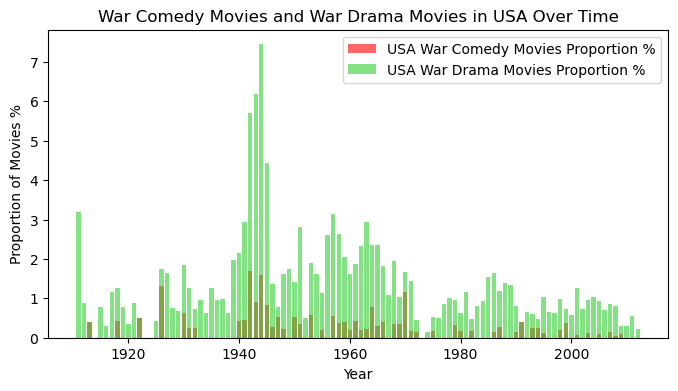

In [73]:
total_movies_per_year = preprocessed_movies.groupby('Year').size()
war_movies_per_year = War_movies.groupby('Year').size()

regions = {
    'EU': ['France', 'United Kingdom', 'Poland', 'Netherlands', 'Belgium', 
           'Sweden', 'Norway', 'Austria', 'Soviet Union', 'Greece', 'Yugoslavia'],
    'USA': ['United States of America']
}

for region, countries in regions.items():
    analyze_war_movies(region, countries, War_movies_comedy, War_movies_drama, total_movies_per_year)

The graph clearly shows that the theme of war is much more frequently portrayed from a dramatic rather than a comedic perspective. However, even if WWII had a global impact, experiences vary greatly from one region of the world to another. When comparing this proportion between European countries where war was being fought and, for example, the United States of America (chosen because it is the largest producer of movies worldwide), we see that the war comedic perspective is much more present.

We know that the distribution of the movies is skewed to the right, so let's focus on the proportion rather than the number of movies.

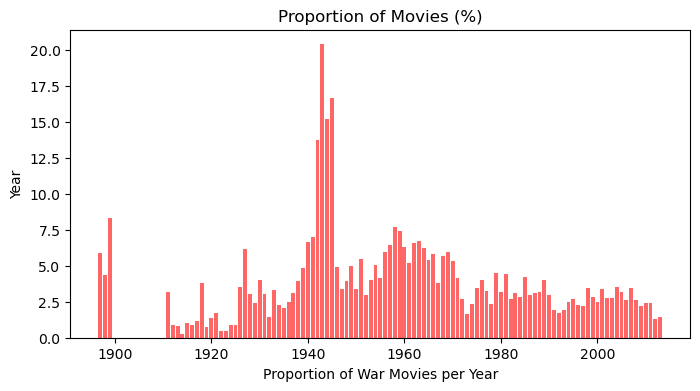

In [74]:
#Proportion of each category of movie per year
war_movies_proportion = (war_movies_per_year / total_movies_per_year)*100
plot_bar(war_movies_proportion.index, war_movies_proportion.values, 'Year', 'Proportion of Movies (%)', 'Proportion of War Movies per Year')

The graph suggests a strong association of war movie production with the World War II era, where the genre’s prominence reached a historical high. We notice a sharp and tempory increase of war movie production. 
We will test if this peak is netherless statisticall significative.

### **➔ Hypothesis testing** :
First we will test if there is a significant difference in war movie production before during and after the WWII.

Null Hypothesis (H0): The proportion of war-themed movies is not significantly different before, during, and after World War II. In other words, WWII had no measurable effect on the trend in war movie production.

Alternative Hypothesis (H1): The proportion of war-themed movies increased significantly as a result of World War II or in the years immediately following it.

In [75]:
periods = {
    "before_WWII": (1930, 1939),
    #As WWI start in september 1939 we will consider the start at 1940
    "during_WWII": (1940, 1945),
    "after_WWII": (1946, 1970)
}

# Proportions of war movies for each period
proportions = {
    name: (War_movies[War_movies['Year'].between(start, end)]
           .groupby('Year').size() / total_movies_per_year.loc[start:end]) * 100
    for name, (start, end) in periods.items()
}

for name, prop in proportions.items():
    print(f"Proportion of war movies {name.replace('_', ' ')}: {prop.mean():.2f}%")

Proportion of war movies before WWII: 3.06%
Proportion of war movies during WWII: 13.26%
Proportion of war movies after WWII: 5.31%


➔ We need to test for normality of the data. Based on the result we could decide to run a parametric or non parametric statistical test:

In [76]:
#Check normality of the before/during/after WWII movies
print('Null Hyopthesis H0: The data are not normally distributed \n')

for name, prop in proportions.items():
    stat, p = shapiro(prop.values)
    print(f"{name.replace('_', ' ').capitalize()} p-value: {p:.4f}")

Null Hyopthesis H0: The data are not normally distributed 

Before wwii p-value: 0.9729
During wwii p-value: 0.4533
After wwii p-value: 0.7265


All the p_values are above 0.05. The data do not significantly deviate from a normal distribution. The test does not provide evidence that the data are non-normal so we will use a parametric test. We will use an ANOVA (Analysis of Variance) test  to determine whether there are statistically significant differences between the means of three or more independent groups. It compares the variance within groups to the variance between groups to identify if at least one group mean is significantly different. Then if ANOVA is significant , the Turkey post-hoc test is used to identify which specific pairs of group means are significantly different from each other. 

In [77]:
all_values = pd.concat([
    pd.DataFrame({'Proportion': prop.values, 'Group': name.split('_')[0].capitalize()})
    for name, prop in proportions.items()
])

# One-Way ANOVA and tukey post-hoc test
anova_pairwise_turkey(all_values)

              sum_sq    df          F        PR(>F)
Group     414.329234   2.0  40.041899  4.408312e-10
Residual  196.600451  38.0        NaN           NaN
There is a significant difference between at least one pair of groups.
        A       B   mean(A)    mean(B)       diff        se         T  \
0   After  Before  5.312585   3.061248   2.251337  0.851068  2.645307   
1   After  During  5.312585  13.261465  -7.948880  1.034036 -7.687237   
2  Before  During  3.061248  13.261465 -10.200217  1.174586 -8.684095   

        p-tukey    hedges  
0  3.098727e-02  1.831940  
1  8.783722e-09 -3.045361  
2  4.412432e-10 -2.868717  


The ANOVA results indicate a significant difference between at least one pair of groups (F = 40.04, p < 0.001), suggesting that the proportions of war movies across the three periods (Before, During, and After WWII) are not equal.

The Tukey post-hoc test reveals the following:

After vs. Before: The difference is significant (p = 0.031), with a mean difference of 2.25, suggesting slightly higher proportions after WWII.
After vs. During: The difference is highly significant (p < 0.001), with a large negative mean difference (-7.95), showing proportions were much higher during WWII compared to after.
Before vs. During: The difference is also highly significant (p < 0.001), with a mean difference of -10.20, indicating a dramatic increase in proportions during WWII compared to before.

### ➔ **Model Fitting** 
Now we will see if we could well explain the trends using year and WWII. 
We will use dummy variables to represent the 3 periods: Before, during and after WWII

We will fit a model with different prediction : year and the dummy variables and see which model perform the best using R_squared value.

In [78]:
# Convert series to a DataFrame
war_movies = war_movies_proportion.to_frame(name='Proportion').reset_index()
war_movies = war_movies[war_movies['Year'] > 1925]

#Create all the dummies variable 
war_movies['Before_WWII'] = (war_movies['Year'] < 1940).astype(int)
# Choose 1941 for the start of WWI because it better fit to the peak of the war movies. Also considering 1 year after the war for the movie production doesn't seem too much .
war_movies['During_WWII'] = ((war_movies['Year'] >= 1941) & (war_movies['Year'] <= 1945)).astype(int)
war_movies['After_WWII'] = (war_movies['Year'] >= 1946).astype(int)

- 1st Case: The predictors chosen are: YEAR, DURING, AFTER
- 2nd Case: The predictors chosen are: BEFORE, DURING, AFTER
- 3rd Case: The predictors chosen are: YEAR and DURING

R-squared for model 1 with Before WWII, During and After WWII as predictors: 0.6747
R-squared for model 2 with Year and During WWII as predictors: 0.6919
R-squared for model 3 with Year, During and After WWII as predictors: 0.7417


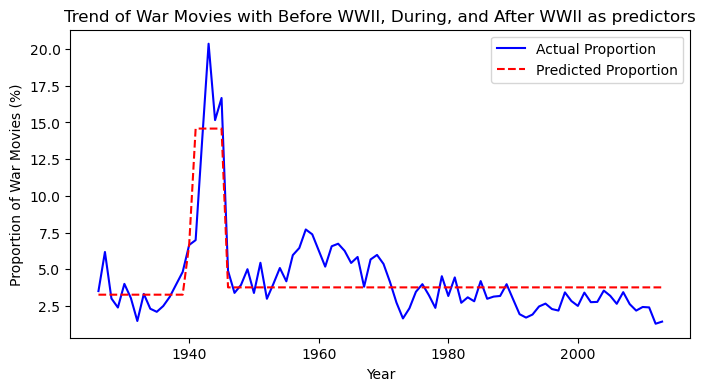

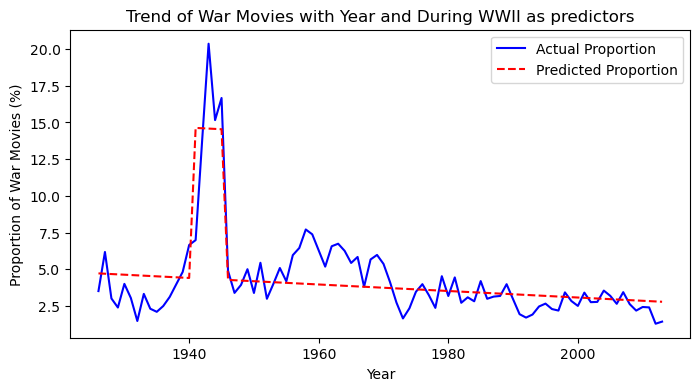

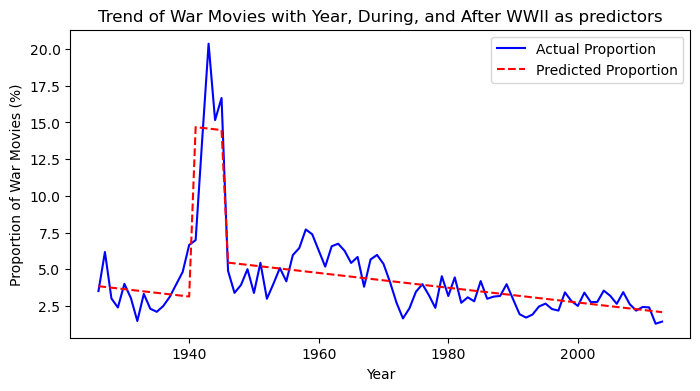

In [79]:
models = [
    (['Before_WWII', 'During_WWII', 'After_WWII'], 'Before WWII, During and After WWII as predictors'),
    (['Year', 'During_WWII'], 'Year and During WWII as predictors'),
    (['Year', 'During_WWII', 'After_WWII'], 'Year, During and After WWII as predictors'),
]

plot_titles = [
    'Trend of War Movies with Before WWII, During, and After WWII as predictors',
    'Trend of War Movies with Year and During WWII as predictors',
    'Trend of War Movies with Year, During, and After WWII as predictors'
]

y = war_movies['Proportion'].values

model_list, predicted_proportions_list, summary_list = evaluate_models(war_movies, models)

# Plot actual vs predicted values for each model
for i in range(3):
    plot_actual_vs_predicted(war_movies['Year'],y,predicted_proportions_list[i],model_list[i],plot_titles[i]
    )

**➔ CONCLUSION:**

Even if all the model are very good performing, the model with the year and the during WWII predictor seems to be the best one with a r squared of **0.73**.

Let's look at this model in more detail:

In [80]:
print(summary_list[2])  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     80.40
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           1.30e-24
Time:                        14:26:50   Log-Likelihood:                -164.75
No. Observations:                  88   AIC:                             337.5
Df Residuals:                      84   BIC:                             347.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         100.8693     19.131      5.273      

R-squared: 0.742 – The model explains approximately 74.2% of the variation in the proportion of war movies.
 
- Year: -0.0504 (p < 0.001) – A relatively low negative trend over time.
- During_WWII: 11.5975 (p < 0.001) – A sharp and significant increase in the proportion of war movies during WWII.
- After_WWII: 2.6147 (p < 0.001) – A smaller but still significant increase after WWII compared to the long-term trend.

The equation of the model is:
$$
Proportion of War Movies=100.8693−0.0504×Year+11.5975×During_WWII+2.6147×After_WWII
$$

The fitted model shows a distinct jump in the predicted war movie proportions during WWII and a recalibrated level afterward, indicating that the war era fundamentally changed the landscape of war film production. Although the model cannot perfectly recreate the actual dramatic spike, the presence of significant dummy variable effects strongly suggests that WWII had a measurable, lasting influence on the proportion of war movies produced.

These results highlight the initial distinction we made: major historical events like wars cause sharp, short-term increases, while broader social movements may lead to more sustained trends over time.

### ★ **Propaganda movies during WWII**

In [81]:
propaganda = preprocessed_movies[preprocessed_movies['Genres'].str.contains(r'propaganda', case=False, na=False)]
propaganda_per_year = propaganda.groupby('Year').size()
propaganda_proportion = (propaganda_per_year / total_movies_per_year)*100

#group propaganda movies by country
propaganda_countries = propaganda['Countries'].str.split(', ').explode().value_counts()
propaganda_countries = propaganda_countries[propaganda_countries > 1]
propaganda_countries = propaganda_countries.sort_values(ascending=False)

nazi_propaganda = preprocessed_movies[preprocessed_movies['Countries'].str.contains(r'nazi', case=False, na=False)]
nazi_propaganda_per_year = nazi_propaganda.groupby('Year').size()
nazi_propaganda_proportion = (nazi_propaganda_per_year / total_movies_per_year)*100

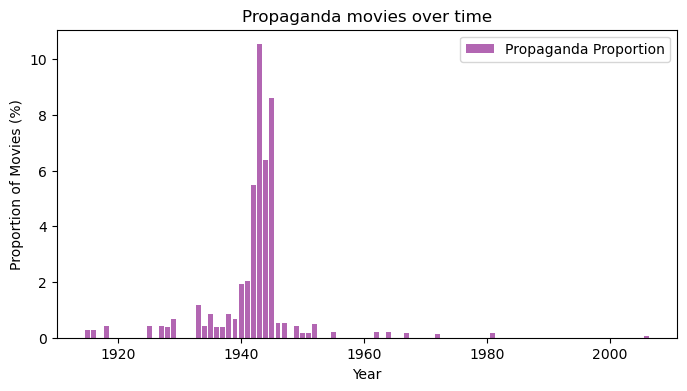

In [82]:
plot_bar(propaganda_proportion.index, propaganda_proportion.values,'Proportion of Movies (%)', 'Propaganda movies over time', label='Propaganda Proportion',color ='Purple')

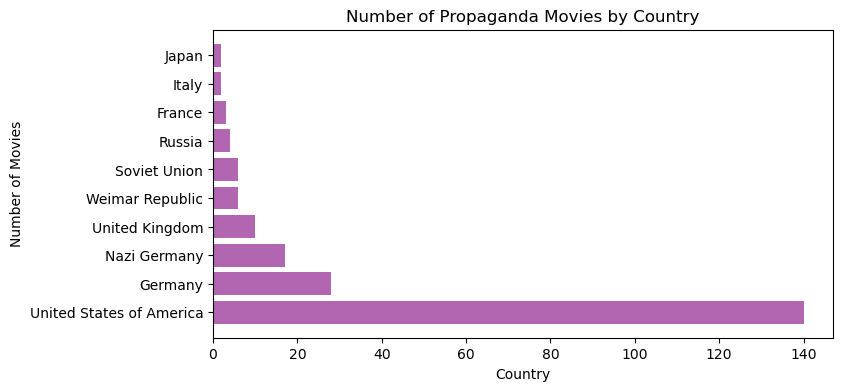

In [83]:

plot_bar(propaganda_countries.index, propaganda_countries.values, 'Country', 'Number of Propaganda Movies by Country', xlabel= 'Number of Movies', color='purple', orientation= 'horizontal')

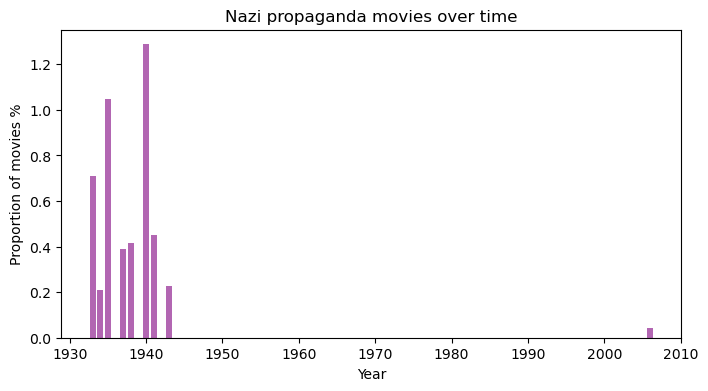

In [84]:
plot_bar(nazi_propaganda_proportion.index, nazi_propaganda_proportion.values,'Proportion of movies %','Nazi propaganda movies over time', color='purple')

We can see that the nazi propaganda movies started in the 30s and lasted until the end of WWII. A single one of them was released in 2006. Is it due to neonazis movements ? Let's investigate what it is.

In [85]:
nazi_propaganda = nazi_propaganda.sort_values(by='Year')
nazi_propaganda.tail(1)

,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
34259,Kampf um Norwegen - Feldzug 1940,NaN,80.0,German,"Nazi Germany, Germany","Short Film, War film, Propaganda film, Documen...",2006


Battle for Norway – Campaign 1940 is a German propaganda film produced by the UFA in 1940 by the High Command of the Wehrmacht.
The film was considered lost for a long time. It was not found by the Norwegian film historian Jostein Saakvitne randomly in 2000 in the offer of a militaria online auction house. These were five film rolls with a total weight of 20 kilograms. The film changed the owner anonymously for less than 1000 euros. 
On the 20th The film first premiered after the war by the film institute Oslo in September 2006. The film was not performed in Germany. 

**➔ CONCLUSION:**

Following the end of WWII, the production of Nazi propaganda films entirely ceased, indicating a clear short-term trend tied directly to the political context. This decline reflects how propaganda films were context-dependent and did not sustain beyond the immediate historical moment.

## ★ WWII and Film Noir

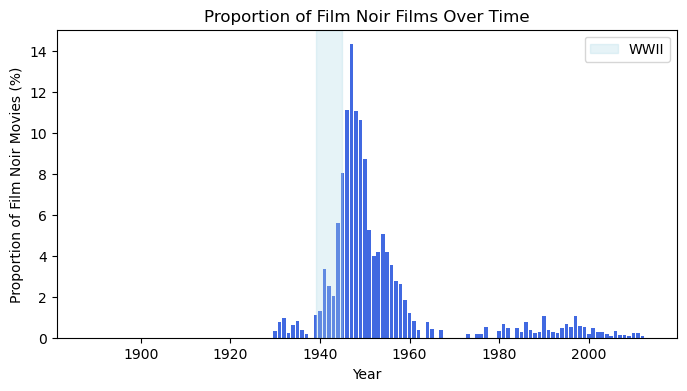

In [86]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'noir', genre_name='Film Noir', event_name='WWII', event_dates=(1939, 1945), is_period=True)

World War II influenced film noir by deepening societal cynicism and disillusionment, as people grappled with the trauma of war, loss, and the harsh realities of post-war life. 

## ★ Watergate Scandal (1972) and Political Films

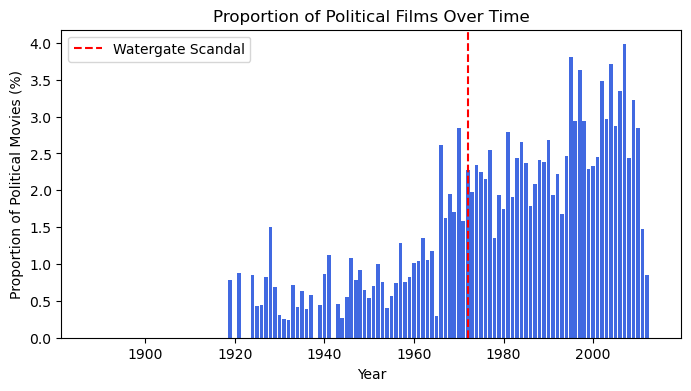

In [87]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, r'political', 'Political', 'Watergate Scandal', (1972, 1972), is_period=False)

From this graph, it is difficult to tell if the Watergate Scandal had a significant impact on the production of political movies globally. 
Let's perform a hypothesis test to compare the proportion of political movies before and after the Watergate.

Null Hypothesis (H0): There is no significant increase in the proportion of political movies following the Watergate scandal.

Alternative Hypothesis (H1): There is a significant increase in the proportion of political movies following the Watergate scandal.

In [88]:
ztest(preprocessed_movies, 1972, r'political')

Proportion of political Movies before 1972: 0.007891770011273957
Proportion of political Movies after 1972: 0.02661269073226819
Z-statistic: 17.09124509452144
P-value: 0.0
Reject the null hypothesis: There is a significant increase in the proportion of political movies.


According to the ztest, the mean proportion of political movies increased significantly following the Watergate. However, we observe that the increase in the proportion of political movies started to increase before the Watergate. To isolate and determine the specific impact of the Watergate scandal, we need to control for other potential factors. 

                            OLS Regression Results                            
Dep. Variable:             Proportion   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     135.7
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           1.06e-38
Time:                        14:26:52   Log-Likelihood:                 479.30
No. Observations:                 126   AIC:                            -950.6
Df Residuals:                     122   BIC:                            -939.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.001     -2.492      0.0

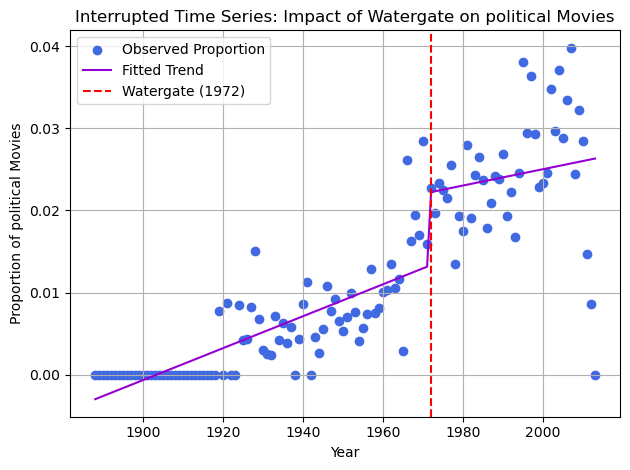

In [89]:
reg_model(preprocessed_movies, 1972, r'political', 'Watergate', 'linear_reg') 

The R-squared value indicates that 76.9% of the variation in the proportion of political movies is explained by the model. The model as a whole is statistically significant (F-statistic (135.7, p = 1.06e-38), meaning it explains a significant portion of the variation in the data. The time coefficient suggests a steady, significant positive trend in the proportion of political movies over time before the Watergate scandal. The Post_Watergate coefficient (0.0169, p = 0.025) shows the immediate jump in the proportion of political movies after the Watergate scandal. However, since films require some time for production, the Watergate scandal is likely not the cause for this steep increase. It might rather be caused by other external factors. Finally, the Time_After coefficient represents the change in the slope of the trend after the Watergate scandal. Since the p-value is > 0.05, this is not statistically significant, meaning there is no strong evidence that the long-term trend changed after the Watergate scandal.

**➔ CONCLUSION:**
 The Watergate scandal did not lead to a sustained change in the rate of increase in political movies. The same analysis performed on films produced exclusively in the USA resulted in the same conclusion. 

## ★ The Cuban Missile Crisis (1962) and Spy Movies

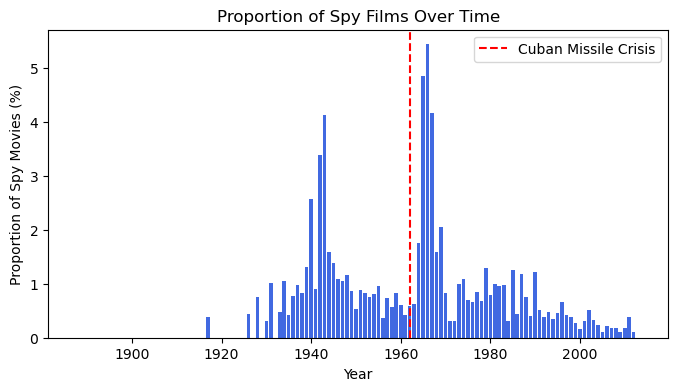

In [90]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, r'spy', 'Spy', 'Cuban Missile Crisis', (1962, 1962), is_period=False)

We notice a big peak following the Cuban Missile Crisis, a time when people were anxious about the threat of nuclear war. This fear likely made Cold War themes feel more relevant and sparked greater interest in the spy genre during that period. To analyse this immediate impact, let's look at the trends in spy movies 15 years before and after the Cuban Missile Crisis.

In [91]:
spy_movies_filtered=preprocessed_movies[(preprocessed_movies['Year'] >= 1947) & (preprocessed_movies['Year'] <= 1977)]
ztest(spy_movies_filtered, 1962, r'spy')

Proportion of spy Movies before 1962: 0.007467575003275252
Proportion of spy Movies after 1962: 0.01720601640838651
Z-statistic: 5.561908923581532
P-value: 1.334197763380729e-08
Reject the null hypothesis: There is a significant increase in the proportion of spy movies.


Let's try to model the peak using a Kernel Density distribution, a flexible method able to capture complex patterns.

Null Hypothesis: The observed distribution of spy movie counts follows the fitted curve (KDE approximation). 

Chi-Square Statistic: 3.10
P-Value: 9.28e-01


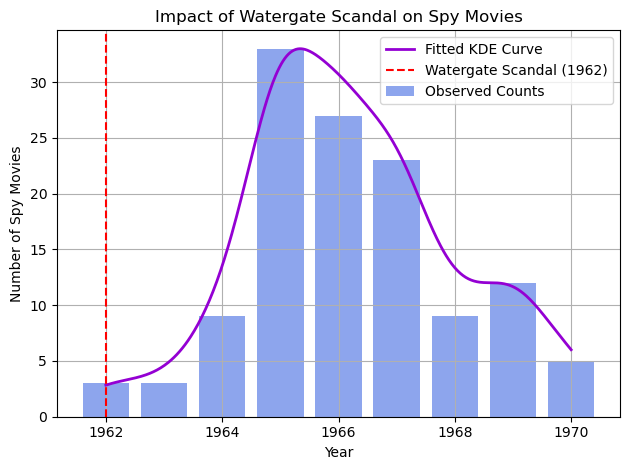

In [92]:
kde_model(preprocessed_movies, start_year=1962, end_year=1970, genre='spy', event_year=1962, event_name='Watergate Scandal')

With a high p-value of 0.928, we fail to reject the null hypothesis. Thus the KDE fits well the significant increase in spy movies after the Cuban Missile crisis. This statistical fits shows that the spike occurred after a delay of two years, which is consistent with the timeline for movie production. The peak and the gradual decline afterward indicate a temporary but strong influence of the crisis on the genre.


## ★ The Atomic Bomb and Creature Movies

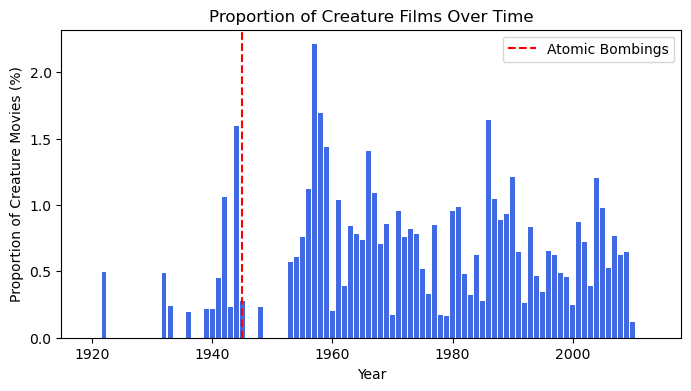

In [93]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, r'creature', 'Creature', 'Atomic Bombings', (1945, 1945), start=1920, is_period=False)

The peak in the number of creature movies between 1955 and 1960 may be linked to the atomic bombings of 1945, though the delay suggests that society needed time to process the trauma and implications of this unprecedented event. The early post-war years likely focused on recovery and reflection, but as the fear of nuclear radiation and its potential effects grew—especially with the onset of the Cold War—these anxieties began to manifest in popular culture.

Creature movies during this period often explored themes of mutation, destruction, and the unknown, reflecting public fears about the consequences of nuclear radiation. However, further analysis is needed to determine the extent to which nuclear concerns directly influenced these films or whether they were part of a broader trend in science fiction and horror responding to the uncertainties of the era.

## ★ Prohibition in the USA (1920-1933) and Crime Movies

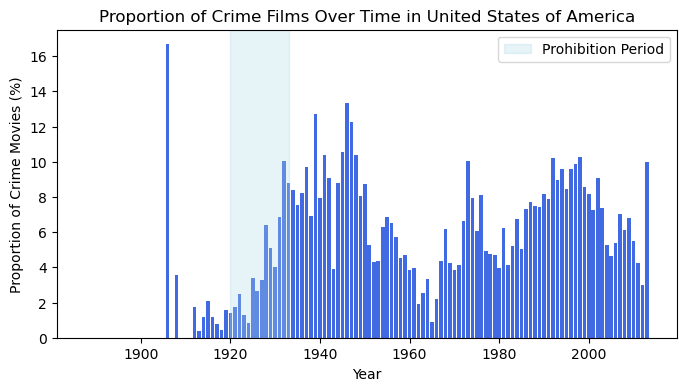

In [94]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, r'gangster|crime', genre_name='Crime', event_name='Prohibition Period', event_dates=(1920, 1933), country='United States of America', is_period=True)

We notice a steep increase in the proportion of crime movies in the United States during the Prohibition. After Prohibition ended, crime remained a  social issue, with lingering effects of organized crime that had taken root during the 1920s. This could explain why the popularity of crime movies remained high until 1945. Following this period, the genre experienced a decline, likely reflecting a shift in public interest.

## ★ WWI and Melodramas 

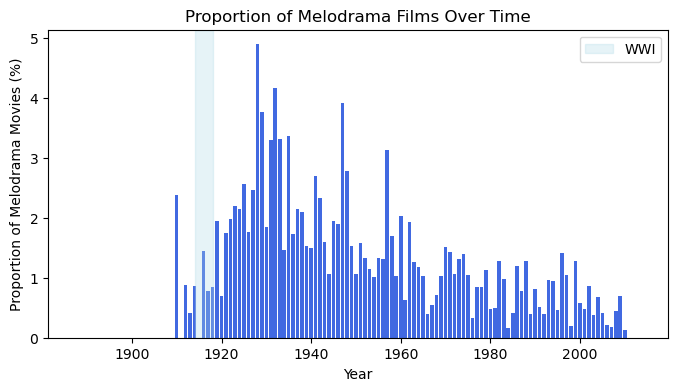

In [95]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'melodrama', genre_name='Melodrama', event_name='WWI', event_dates=(1914, 1918), is_period=True)

The aftermath of World War I left people grappling with loss, grief, and the search for meaning. Melodramas, with their intense focus on human struggles and emotional resolution, provided catharsis for audiences dealing with these societal changes.

###  ★ **The Great Depression and the Rise of Musicals as an Escape**

As we saw at the beginning of this notebook, we can see a rise of musical genre in the 30s.

For this study, we will focus on U.S. production because, as shown below, the number of American movies accounts for half of the worldwide film industry:

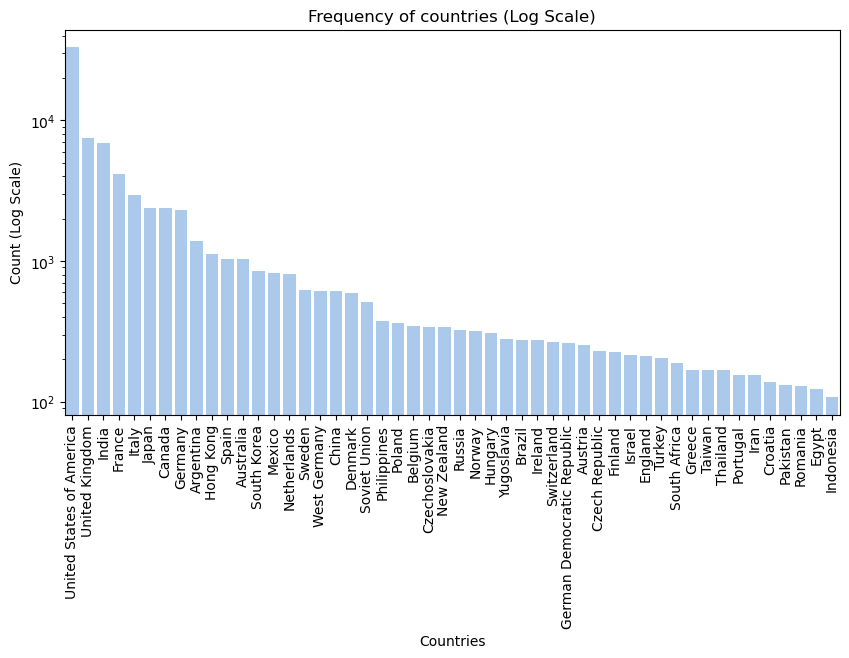

The number of American movies is 33104 which corresponds to 48.59% of the total number of movies.


In [96]:
top_n = 50

countries_counts = preprocessed_movies['Countries'].str.split(', ').explode().value_counts()
top_countries = countries_counts.head(top_n)
top_countries_df = top_countries.reset_index()
top_countries_df.columns = ['Countries', 'Count']

#Using a logarithmic scale
plt.figure(figsize=(10,5))
sns.barplot(x='Countries', y='Count', data=top_countries_df)
plt.xticks(rotation=90)
plt.yscale('log')
plt.title('Frequency of countries (Log Scale)')
plt.ylabel('Count (Log Scale)')
plt.show()

# show the percentage of english language movies compared to the total number of movies
american_movies = preprocessed_movies['Countries'].str.contains('United States of America').sum()
print(f"The number of American movies is {american_movies} which corresponds to {american_movies/len(preprocessed_movies)*100:.2f}% of the total number of movies.")

In [97]:
# events in the USA starting from 1925 to 1930
USA_events = preprocessed_history[preprocessed_history['Country'] == 'United States of America']
USA_events = USA_events[USA_events['Year'].between(1925, 1930)].sort_values(by='Year')
USA_events.head()

,Name of Incident,Year,Country,Type of Event,Impact,Affected Population,Important Person/Group Responsible,Outcome
621,Stock Market Crash of 1929,1929,United States of America,Economic,"Led to the Great Depression, impacting global ...",Global population,Unknown,Negative


**Hypothesis**: The Great Depression stimulated the rise of musical films due to the need for escapism and entertainment.

The Great Depression, starting with the 1929 stock market crash, led to widespread economic hardship, with unemployment rates exceeding 25% and significant declines in industrial output. In this period of despair, people sought escapism and affordable entertainment to cope with the harsh realities of daily life. However the rise and maintaining of the musical genre is not only due to the need for escapism during the Great Depression, but also because the advent of synchronized sound (The Jazz Singer in 1927) revolutionized the industry, allowing dialogue, music, and dance to be seamlessly integrated into films. Before the late 1920s, films were silent, with music provided by live orchestras. 

## **II) Impact of technological advancements**

In this section we will study these events: 

10) **Science Fiction Movies/ Special effects advancements**

11) **Black and white movies/ Technicolor technique**

12) **Silent Movies/ Sound technologies**

## ★ Major special effects advancements (late 1970s) and Science-Fiction Movies


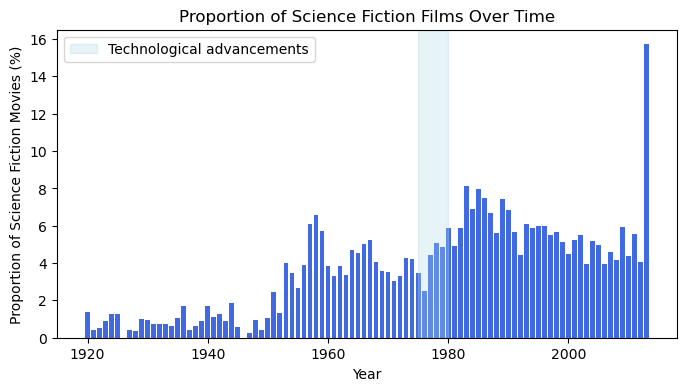

In [98]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'Science Fiction', genre_name='Science Fiction', event_name='Technological advancements', event_dates=(1975, 1980), start=1920, is_period=True)

There is a steep increase in the proportion of science-fiction movies starting in the mid-1970s, which coincides with the rise of the blockbuster era. This growth is likely driven by the integration of advanced visual effects techniques, such as Computer-Generated Imagery (CGI), introduced between 1973 and 1982, along with motion control cameras and animatronics, which became widely used in the late 1970s. Additionally, the surge in the 1980s may be linked to renewed public interest in space exploration, due to the launch of the Space Shuttle program in 1981 for example.

## ★ Technicolor technique (1916) and Black-and-white Movies


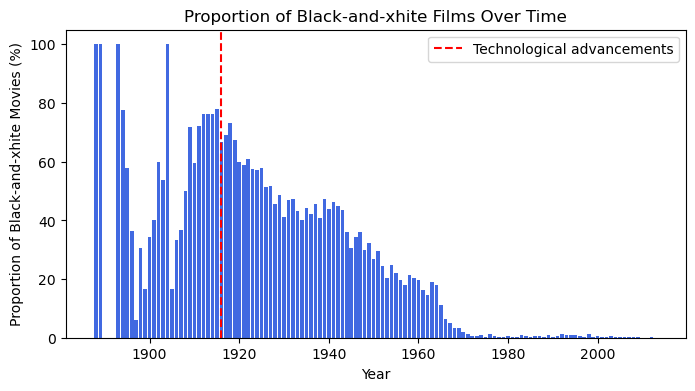

In [99]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'Black-and-white', genre_name='Black-and-xhite', event_name='Technological advancements', event_dates=(1916, 1916), is_period=False)

The decline of the prevalence of black-and-white movies can be easily explained by the invention of the first technicolor technique in 1916, which was later improved. Progressivly, color films became more affordable and accessible and overtakook black-and-white movies.


## ★ Sound Technologies (1927) and Silent Movies


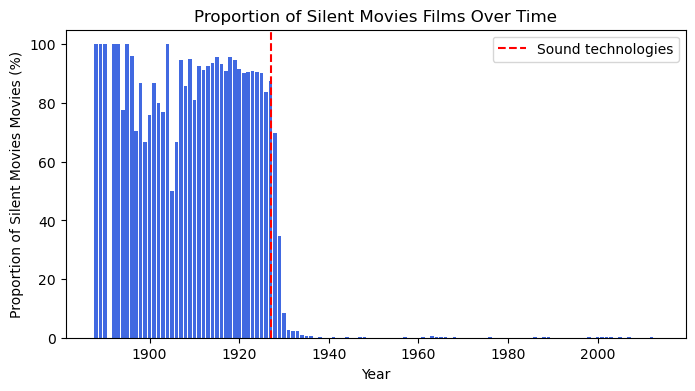

In [100]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'Silent', genre_name='Silent Movies', event_name='Sound technologies', event_dates=(1927, 1927), is_period=False)

The introduction of sound in movies became possible with the Vitaphone system invented in 1927. The release of The Jazz Singer, the first movie with dialogue and music, was a turning point. Silent films became rapidly obsolete.

## **III) Impact of commercial successes**

Here we will focus on: 

13) **Slasher films/ First slasher commercial succes**

14) **Art Martial Movies/ Bruce Lee successes**

## ★ Slasher Films

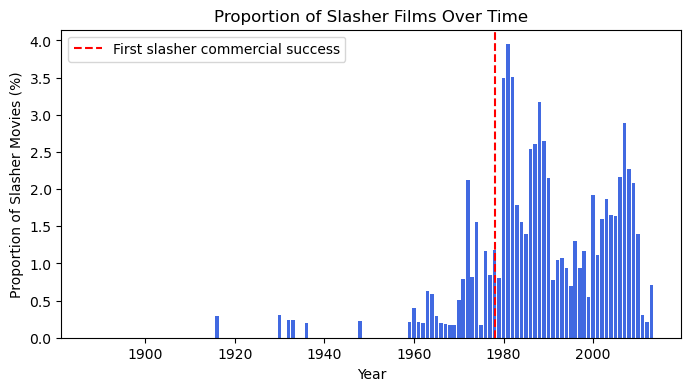

In [101]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'slasher', genre_name='Slasher', event_name='First slasher commercial success', event_dates=(1978, 1978), is_period=False)

Some early slasher movies had an important economic successes. For example, Halloween (1978) is low-budget film that grossed $70 million, proving the profitability of the genre. Studios quickly capitalized on the trend, producing a flood of slasher films to meet audience demand. In the 1980s, the genre is flourishing, accounting for 4% of movies worldwide. Moreover, the rise of VHS in the 1980s allowed slasher films to thrive beyond theaters. These movies were inexpensive to produce and highly profitable on home video.

## ★ Bruce Lee And Martial Arts Films

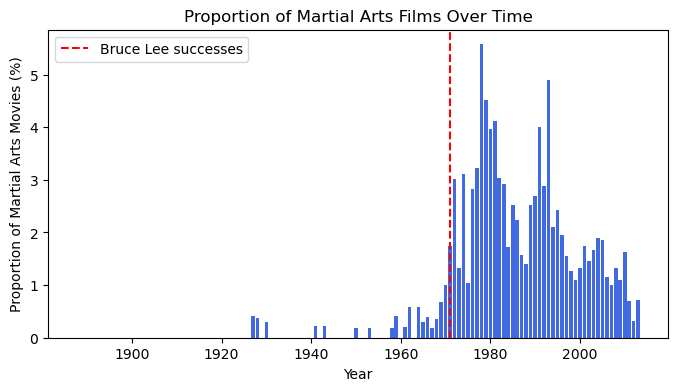

In [102]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'martial', genre_name='Martial Arts', event_name='Bruce Lee successes', event_dates=(1971, 1971), is_period=False)

Bruce Lee’s first movies revolutionized martial arts in the cinema industry. In particular, his first commercial success, The Big Boss (1971), marked the beginning of the expansion of the genre. Martial arts films were inexpensive to produce, allowing studios to produce many movies rapidly and capitalize on the genre’s popularity. The 1970s marked the Golden Age of Hong Kong Cinema, with studios like Shaw Brothers and Golden Harvest dominating the martial arts genre.

## **IV) Impact of cultural movements**

Then we will be paying particular attention to:

13) **LGBT Movies/ Gay rights movements**

14) **Western Movies/ Indian Civil Rights Act**

15) **Horror and Teen Movies/ Teen Culture**

16) **Sex Comedies/ Sexual Revolution**


###  ★ **LGBT Movies and Gay rights movements**

Unlike wars, which are typically time-bound events with a clear beginning and end, the emergence of LGBT representation in cinema is more closely tied to long-term social progress. We thus hypothesis that key milestones, such as the first pride marches or significant legal advancements will not produce sudden spikes but instead contribute to a gradual, sustained increase in the production of LGBT-themed movies over time.

In [103]:
lgbt_movies = preprocessed_movies[preprocessed_movies['Genres'].str.contains(r'lgbt', case=False, na=False)]
lgbt_movies = lgbt_movies[lgbt_movies['Year'] < 2011]
lgbt_movies_per_year = lgbt_movies.groupby('Year').size()
lgbt_movies_proportion = (lgbt_movies_per_year / total_movies_per_year)*100
lgbt_events = preprocessed_history[preprocessed_history['Affected Population'].str.contains(r'lgbt', case=False, na=False)]
lgbt_events = lgbt_events[lgbt_events['Year'] < 2010]

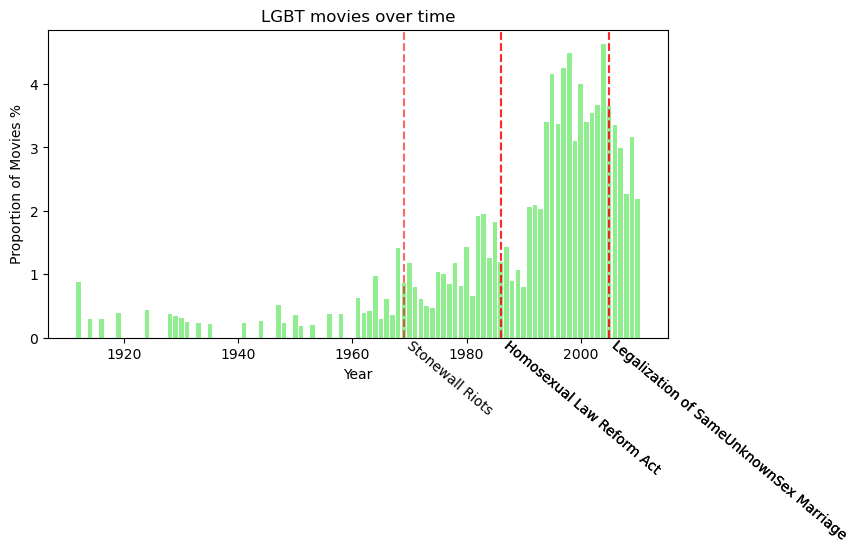

In [104]:
plot_bar_and_event(lgbt_events,lgbt_movies_proportion, 'LGBT movies over time')

### **➔ USA Case study**

We focus on movies released in the USA that are classified as LGBT-themed, as they represent the largest proportion of LGBT movies in the dataset. We created a smaller dataset featuring major events for the LGBT community in the USA. Our goal is to determine whether there is a significant increase in movie releases tied to specific events or whether the increase is driven solely by time.  

We excluded all films released after 2010 because the dataset shows a general decline in the number of films during that period, which appears to negatively impact our model's performance. 

In [105]:
usa_lgbt_movies = lgbt_movies[lgbt_movies['Countries']=='United States of America']
usa_lgbt_movies = usa_lgbt_movies[usa_lgbt_movies['Year'] < 2011]

total_movies_per_year_usa = preprocessed_movies[preprocessed_movies['Countries']=='United States of America'].groupby('Year').size()

print(f"Number of LGBT movies in United States {len(usa_lgbt_movies)}")
usa_lgbt_movies_per_year = usa_lgbt_movies.groupby('Year').size()
usa_lgbt_movies_proportion = (usa_lgbt_movies_per_year / total_movies_per_year)*100

Number of LGBT movies in United States 476


In [106]:
data = {
    "Year": [1924, 1969, 1973, 2004],
    "Name of Incident": [
        "Society for Human Rights",
        "Stonewall Riots",
        "Homosexuality Removed from mental disorders",
        "Same-Sex Marriage legalizes in first U.S. state"
    ],
    "Description": ["first documented gay rights organization in the U.S. is founded in Chicago by Henry Gerber",
                    "A watershed moment that catalyzed the modern LGBTQ+ rights movement, leading to the first Pride marches",
                    "The American Psychiatric Association removes homosexuality from its list of mental disorders, marking a major step toward acceptance",
                    "The first U.S. state to legalize same-sex marriage, setting the stage for national recognition"
    ]               
}

usa_lgbt_events= pd.DataFrame(data)

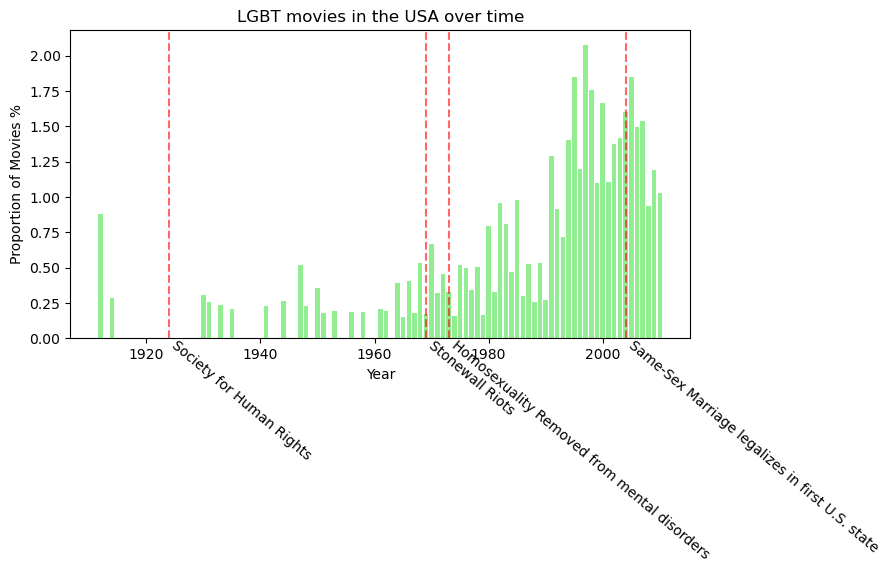

In [107]:
plot_bar_and_event(usa_lgbt_events,usa_lgbt_movies_proportion, 'LGBT movies in the USA over time')

### ➔ **Hypothesis testing** : 
The prevalence of LGBT-themed movies follows a gradual temporal trend rather than experiencing significant shifts in response to key milestone events.

This suggests that changes in the number or proportion of LGBT-themed movies are more strongly correlated with the passage of time (a continuous trend) rather than being directly triggered by major historical or social events.

### ➔ **Model fitting**: 
To test this, we will use a linear regression model with various predictors, similar to the approach used for war movies. We will evaluate which model best explains the data.

*1st case: year as the only predictor*

                                 OLS Regression Results                                
Dep. Variable:                 Counts   R-squared (uncentered):                   0.857
Model:                            OLS   Adj. R-squared (uncentered):              0.852
Method:                 Least Squares   F-statistic:                              185.8
Date:                Thu, 19 Dec 2024   Prob (F-statistic):                    6.57e-27
Time:                        14:26:56   Log-Likelihood:                         -19.994
No. Observations:                  64   AIC:                                      43.99
Df Residuals:                      62   BIC:                                      48.31
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

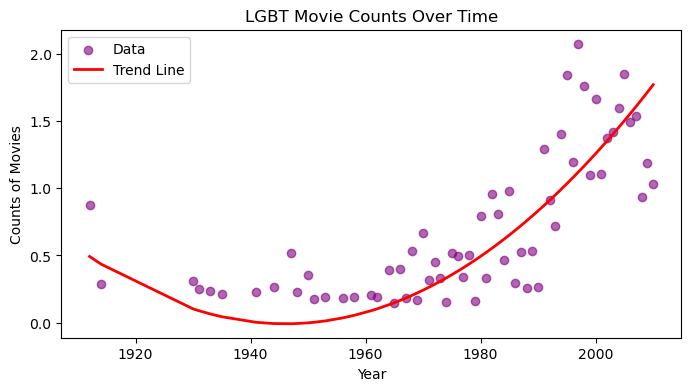

In [108]:
df = usa_lgbt_movies_proportion.reset_index()
df.columns = ['Year', 'Counts']
df['Year_centered'] = df['Year'] - df['Year'].mean()
df['Year_squared'] = df['Year_centered']**2  # Add quadratic term
df.dropna(inplace=True)

#think make more sens to not add an intercept in this case
#X = sm.add_constant(df[['Year_centered', 'Year_squared']])
X= df[['Year_centered', 'Year_squared']]
y = df['Counts']

# Fit the linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())

# Get predictions for plotting the trend line
pred = model.predict(X)

plot_lgbt_movie_trend(df, pred)

We used Ordinary Least Squares (OLS) regression with a quadratic term.

R value: = 0.86 --> the quadratic model explains 86% of the variance in LGBT movie counts

Coefficients:
- Year_centered: A coefficient of 0.3878 (p < 0.001) indicates a positive linear trend in LGBT movie counts over time.
- Year_squared: The positive coefficient of 0.0072 (p < 0.001) suggests a non-linear trend, with acceleration at certain points.

Both Year_centered and Year_squared terms are highly significant, showing the importance of both linear and quadratic effects.

The high F-statistic (102.0) and p-value (3.50e-20) confirm the model's strong fit overall.

*2nd case: Keymilestones as dummy predictor*

In [109]:
#We will define the following periods of 5 years as the one folowwing key milestone: 
usa_lgbt_movies = usa_lgbt_movies_proportion.to_frame(name='Proportion').reset_index()

#Society for human rights (1924)
usa_lgbt_movies['shr_period'] = (usa_lgbt_movies['Year']>=1925) & (usa_lgbt_movies['Year']<=1930).astype(int)

#StoneWall riots (1969) & Homosexuality removed from mental disorders (1973)
usa_lgbt_movies['stone_wall_period'] = (usa_lgbt_movies['Year']>=1974) & (usa_lgbt_movies['Year']<=1979).astype(int)    

#Same sex mariage legalizes in first U.S. state (2004)
usa_lgbt_movies['marriage_legalized_period'] = (usa_lgbt_movies['Year']>=2005) & (usa_lgbt_movies['Year']<=2010).astype(int)

In [110]:
X = usa_lgbt_movies[['shr_period', 'stone_wall_period', 'marriage_legalized_period']].astype(float)
y = usa_lgbt_movies['Proportion'].values

# Drop rows wherexand  y is NaN
X = X[~np.isnan(y)]
y = y[~np.isnan(y)]

model, predicted_proportions1, summary = fit_and_evaluate_model(X, y)

r2 = r2_score(y, predicted_proportions1)
print(f"R-squared: {r2:.4f}")

R-squared: 0.1846


As we could have guessed from the bar plot, the model with only the predictors does not explain much of the variability in the data. There is no clear change observed after each event. Let’s try selecting only the key milestones that appear to have an influence on the plot (for example the period after Stonewall). We will also keep the year as a predictor.

In [111]:
usa_lgbt_movies['Year_centered'] = usa_lgbt_movies['Year'] - usa_lgbt_movies['Year'].mean()
usa_lgbt_movies['Year_squared'] = usa_lgbt_movies['Year_centered']**2

X = usa_lgbt_movies[['Year_centered','Year_squared','stone_wall_period',]].astype(float)
y = usa_lgbt_movies['Proportion'].values

# Drop rows where x and y are NaN
X = X[~np.isnan(y)]
y = y[~np.isnan(y)]


model, predicted_proportions2, summary = fit_and_evaluate_model(X, y)

r2 = r2_score(y, predicted_proportions2)
print(f"R-squared: {r2:.4f}")

R-squared: 0.6774


This model performs worse in explaining the variance of our data compared to the first one.

## ★ Indian Civil Rights Act (1968) and Western Movies

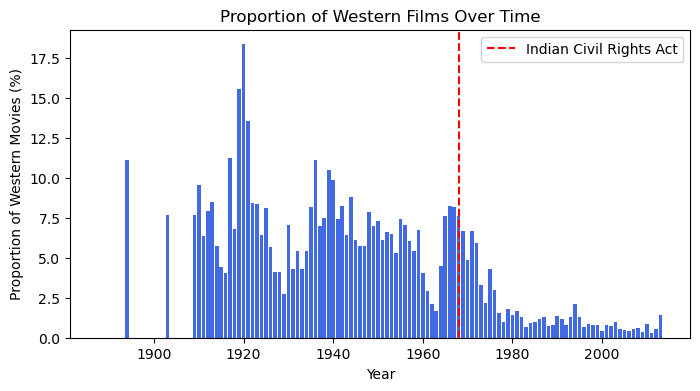

In [112]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'western', genre_name='Western', event_name='Indian Civil Rights Act', event_dates=(1968, 1968), is_period=False)

After the Indian Civil Rights Act of 1968, we notice a stronger decrease of the proportion of western movies, which becomes negligible in the 1980s. This likely reflects the changing societal attitudes and a growing awareness of the historical injustices faced by Native American communities. 

## ★ Option : Teen Culture (1970s-1980s): Horror movies and Teen Movies

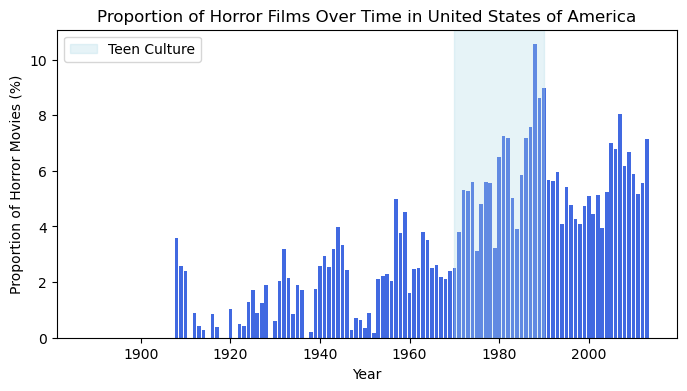

In [113]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'horror', genre_name='Horror', event_name='Teen Culture', event_dates=(1970, 1990), country='United States of America', is_period=True)


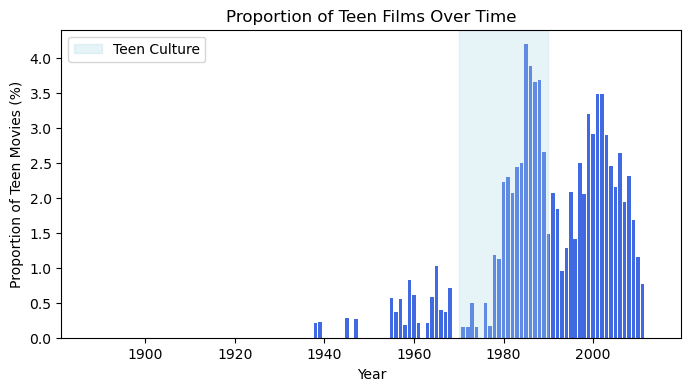

In [114]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'teen', genre_name='Teen', event_name='Teen Culture', event_dates=(1970, 1990), is_period=True)

A développer selon les envies

## ★ Option : Sex comedies and the Sexual Revolution

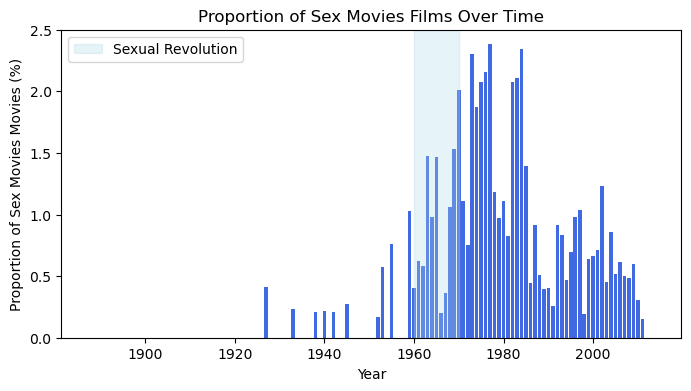

In [115]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'sex', genre_name='Sex Movies', event_name='Sexual Revolution', event_dates=(1960, 1970), is_period=True)

A développer selon les envies

## **V) Globalization and integration policies**

Finally we will investigate:

17) **Chinese Movies/ Cultural revolution**

18) **Japanese Movies/ Post WWII occupation**

19) **Bollywood/ Indian independance**

## ★ The Cultural Revolution (1966-1976) and chinese movies

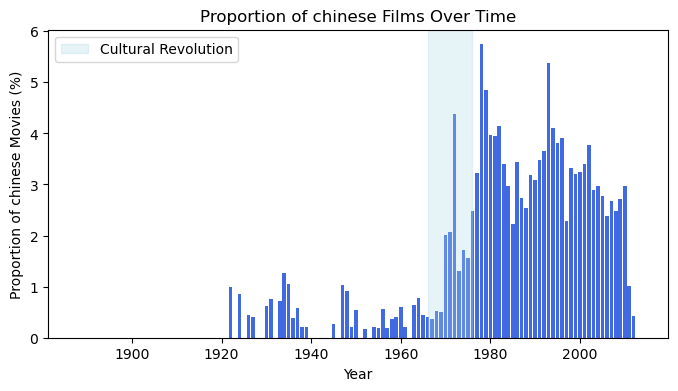

In [116]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'chinese', genre_name='chinese', event_name='Cultural Revolution', event_dates=(1966, 1976), is_period=True)

During the Cultural Revolution, we notice a peak of chinese movies because cinema was heavily used by the Communist Party as a tool for propaganda to promote Maoist ideology and revolutionary values. While traditional theater, music, and literature were suppressed or destroyed during the Cultural Revolution, the movie industry was promoted. Films such as The Red Detachment of Women (1970) and Taking Tiger Mountain by Strategy (1970) were mandated for public viewing and became some of the most widely screened movies of the time.

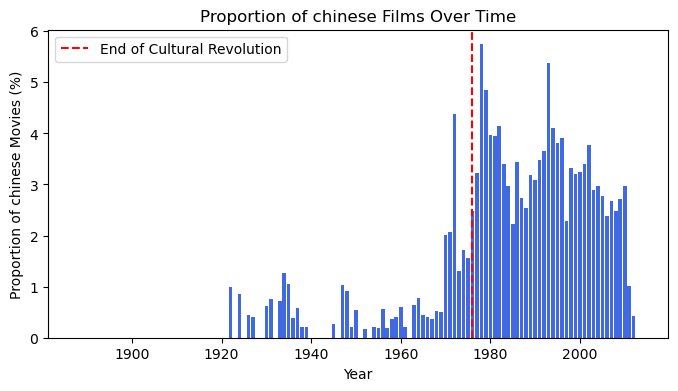

In [117]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'chinese', genre_name='chinese', event_name='End of Cultural Revolution', event_dates=(1976, 1976), is_period=False)


The end of the Cultural Revolution in 1976 marked the decline of extreme political control over artistic expression. Filmmakers gained more freedom to explore diverse narratives. Moreover, Deng Xiaoping initiated an Opening-up Policy in 1978 to welcome foreign investment, cultural exchanges, and globalization. Soon, the proportion of chinese movies reached a peak in the early 1980s, demonstrating China's desire to showcase its culture globally.

## ★ Post WWII occupation and Japanese movies

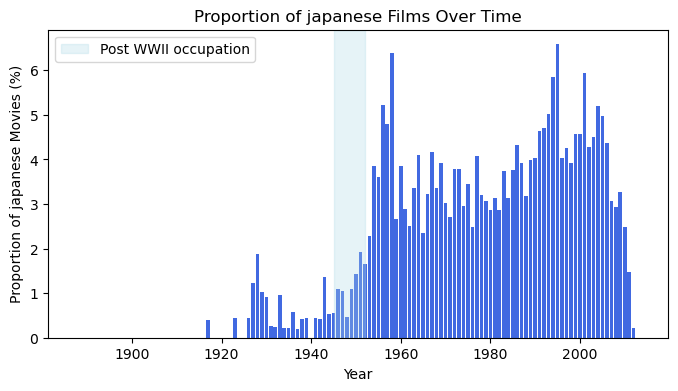

In [118]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'japanese', genre_name='japanese', event_name='Post WWII occupation', event_dates=(1945, 1952), is_period=True)

Post-WWII, Japan experienced rapid industrial growth and urbanization during the U.S. occupation (1945–1952) and beyond. Increased national income allowed for the expansion of cultural industries, including film production. Japanese filmmakers used cinema to explore themes of loss, recovery, and societal change, reflecting the nation's journey after the devastation of WWII. Films became a tool of soft power, showcasing Japanese culture and values to the world.

## ★ Indian Independance (1947) and Bollywood

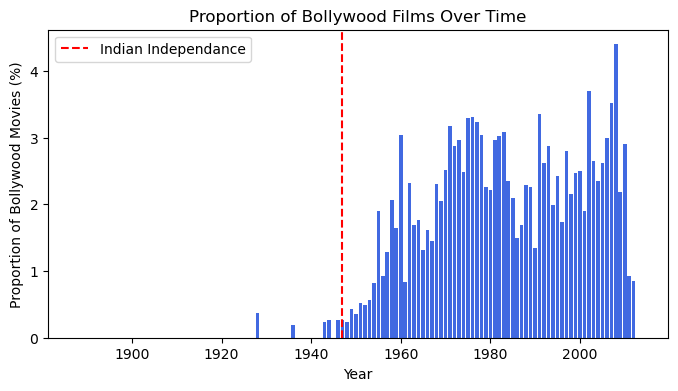

In [119]:
plot_genre_proportion_and_event(preprocessed_movies, total_movies_per_year, 'bollywood', genre_name='Bollywood', event_name='Indian Independance', event_dates=(1947, 1947), is_period=False)

The rise of Bollywood movies begins right after the Indian Independence of 1947. This major event of Indian history exacerbated feelings of national pride, social justice, and unity, which are reflected in Bollywood films like Mother India (1957). Bollywood became a cultural ambassador, spreading Indian culture, music, and traditions globally. In the 1991, India adopted economic liberalization and opened its economy to global markets. This shift towards globalization is reflected in the increase of Bollywood movies in the 1990s

## **II) Predicting the Impact of Historical Events on the Film Industry**

Is it possible to build a classifier to predict whether an event will have an **Immediate Spike** or a **Long-Term Influence** on movie genre trends based solely on its name, year, location, impact type, and description? This is the question we are about to answer in this section.
Vraiment que si on a le temps pas la priorité ca risque d'echouer vu le manque de data.